<a href="https://colab.research.google.com/github/LueMar-R/P36_R_HousingPrices/blob/main/Colab_R_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housing Price Prediction with R

## Environment setting

In [1]:
%load_ext rpy2.ipython

In [1]:
%%R
install.packages("shiny")

In [1]:
%%R
install.packages('randomForest')
install.packages('caret')
install.packages('corrplot')
install.packages('MLmetrics')

In [1]:
%%R
library(tidyverse) # utility functions
library(rpart) # for regression trees
library(modelr) # add predictions to a data frame
library(randomForest) # for random Forests
library(shiny) # Vizualisation
library(corrplot) # for correlation matrix
library(caret) # for metrics

## Data Preprocessing

#### Data loading and analysis

In [5]:
%%R
df <- read_csv("/content/sample_data/california_housing_train.csv")
summary(df)


── Column specification ────────────────────────────────────────────────────────
cols(
  longitude = col_double(),
  latitude = col_double(),
  housing_median_age = col_double(),
  total_rooms = col_double(),
  total_bedrooms = col_double(),
  population = col_double(),
  households = col_double(),
  median_income = col_double(),
  median_house_value = col_double()
)

   longitude         latitude     housing_median_age  total_rooms   
 Min.   :-124.3   Min.   :32.54   Min.   : 1.00      Min.   :    2  
 1st Qu.:-121.8   1st Qu.:33.93   1st Qu.:18.00      1st Qu.: 1462  
 Median :-118.5   Median :34.25   Median :29.00      Median : 2127  
 Mean   :-119.6   Mean   :35.63   Mean   :28.59      Mean   : 2644  
 3rd Qu.:-118.0   3rd Qu.:37.72   3rd Qu.:37.00      3rd Qu.: 3151  
 Max.   :-114.3   Max.   :41.95   Max.   :52.00      Max.   :37937  
 total_bedrooms     population      households     median_income    
 Min.   :   1.0   Min.   :    3   Min.   :   1.0   Min.   : 0.4999  
 1st Qu

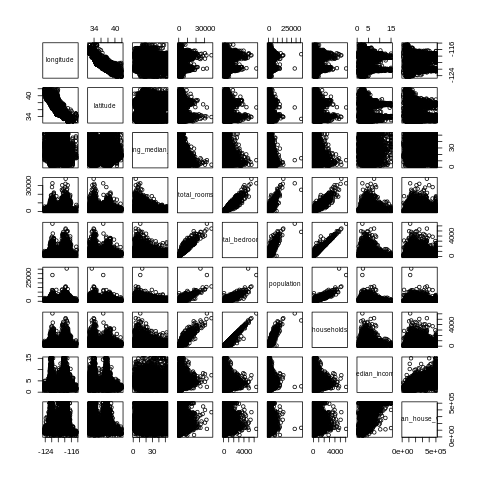

In [6]:
%%R
# pairplot
pairs(df)

In [7]:
%%R
# correlation matrix 
cor(df)

                     longitude    latitude housing_median_age total_rooms
longitude           1.00000000 -0.92520828         -0.1142503  0.04701044
latitude           -0.92520828  1.00000000          0.0164539 -0.03877257
housing_median_age -0.11425031  0.01645390          1.0000000 -0.36098417
total_rooms         0.04701044 -0.03877257         -0.3609842  1.00000000
total_bedrooms      0.07180196 -0.06937292         -0.3204341  0.92840299
population          0.10167426 -0.11126136         -0.2958898  0.86017034
households          0.05962770 -0.07490230         -0.3027542  0.91901830
median_income      -0.01548496 -0.08030301         -0.1159316  0.19538281
median_house_value -0.04498170 -0.14491672          0.1067577  0.13099147
                   total_bedrooms    population   households median_income
longitude              0.07180196  0.1016742646  0.059627704 -0.0154849614
latitude              -0.06937292 -0.1112613615 -0.074902297 -0.0803030138
housing_median_age    -0.32043408 -

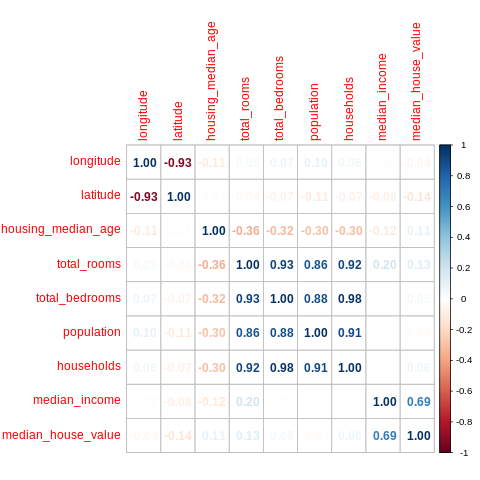

In [8]:
%%R
# correlation matrix with corrplot library
corrplot(cor(df), method = 'number')

#### Preprocessing

In [9]:
%%R
#missing data
sum(is.na(df)) 

#df <- na.omit(df)
# as there is no NA Values here, we don't need to execute this last command

[1] 0


In [10]:
%%R
#train test split

set.seed(42)
df=df[sample(nrow(df)),]
select.data= sample (1:nrow(df), 0.7*nrow(df))
train.data= df[select.data,]
test.data= df[-select.data,]

print("Number of sample in train and test sets :")
print(nrow(train.data))
print(nrow(test.data))

[1] "Number of sample in train and test sets :"
[1] 11900
[1] 5100


## Training

### Decision Tree Regressor

In [11]:
%%R
#  decision tree
fit <- rpart(median_house_value ~ longitude + latitude + housing_median_age + total_rooms +
             total_bedrooms + population + households + median_income, data = train.data)

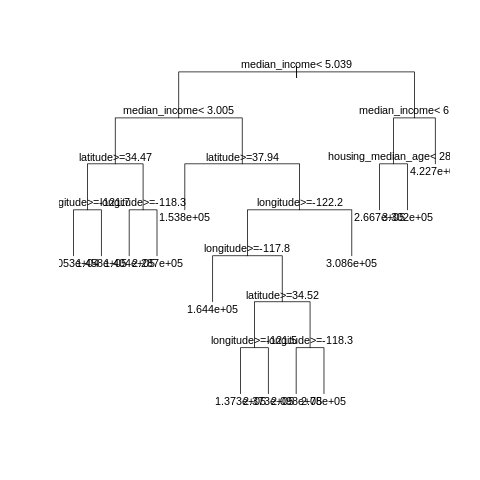

In [12]:
%%R
# plot tree 
plot(fit, uniform=TRUE)

text(fit, cex=.9)

In [13]:
%%R
print("Predictions of the decision tree for the five first houses :")
print(predict(fit, head(test.data[-9])))

print("Actual prices")
print(head(test.data$median_house_value))

[1] "Predictions of the decision tree for the five first houses :"
        1         2         3         4         5         6 
 90532.36 278017.41 153839.21 237252.33 422703.08 308595.10 
[1] "Actual prices"
[1]  40900 225200  98900 220800 406700 500001


In [14]:
%%R
print("Metrics")
y_p1 = predict(fit, test.data[-9])

res1 <-postResample(pred = y_p1, obs = test.data$median_house_value)
print(res1)

[1] "Metrics"
        RMSE     Rsquared          MAE 
7.635315e+04 5.702031e-01 5.635402e+04 


### Random Forest Classifier

In [16]:
%%R
#To perform Random Forest Operation
classifier= randomForest(x=train.data[-9],y=train.data$median_house_value,ntree = 10)

y_pred=predict(classifier, newdata = test.data[-9])
print("Predictions of the random forest for the five first houses :")
print(head(y_pred))
print("Actual price")
print(head(test.data$median_house_value))

[1] "Predictions of the random forest for the five first houses :"
        1         2         3         4         5         6 
 81494.67 232497.67 137275.00 185572.67 381443.00 326085.67 
[1] "Actual price"
[1]  40900 225200  98900 220800 406700 500001


In [17]:
%%R
print("Metrics")
res <-postResample(pred = y_pred, obs = test.data$median_house_value)
print(res)

[1] "Metrics"
        RMSE     Rsquared          MAE 
5.627807e+04 7.691708e-01 3.855126e+04 


In [18]:
%%R
save(classifier, file="model.Rdata")

## Visualization interface with Shiny

In [19]:
%%R

# Define UI for app that draws a histogram ----
ui <- fluidPage(

  # App title ----
  titlePanel("Housing Price Prediction"),

  # Sidebar layout with input and output definitions ----
  sidebarLayout(

    # Sidebar panel for inputs ----
    sidebarPanel(

      # Input: Sliders for (longitude + latitude + housing_median_age + total_rooms +
             # total_bedrooms + population + households + median_income)
      sliderInput(inputId = "longitude",
                  label = "Longitude",
                  min = -124,
                  max = -113,
                  value = -120),
    sliderInput(inputId = "latitude",
                  label = "Latitude",
                  min = 33,
                  max = 41,
                  value = 37),
    sliderInput(inputId = "housing_median_age",
                  label = "Housing median age",
                  min = 1,
                  max = 52,
                  value = 25),
    sliderInput(inputId = "total_rooms",
                  label = "Total rooms",
                  min = 2,
                  max = 50000,
                  value = 500),
    sliderInput(inputId = "total_bedrooms",
                  label = "Total bedrooms",
                  min = 1,
                  max = 6445,
                  value = 100),
    sliderInput(inputId = "population",
                  label = "Population",
                  min = 3,
                  max = 35682,
                  value = 150),
    sliderInput(inputId = "households",
                  label = "Households",
                  min = 1,
                  max = 6082,
                  value = 100),
    sliderInput(inputId = "median_income",
                  label = "Median income",
                  min = 1,
                  max = 15,
                  value = 5)),
    

    mainPanel(
      tableOutput("predict")

    )
  )
)


y_rrr = predict(classifier, newdata=list(-125, 35, 5, 5, 5, 5, 5, 5))
print(y_rrr)

# Define server logic required ----
server <- function(input, output) {
  
  # 1. It is "reactive" and therefore should be automatically
  #    re-executed when inputs (input$longitude, etc.) change
  # 2. Its output type is a Table
  predictions <- reactive({
    preprocessInput = data.frame(
      longitude = as.integer(input$longitude),
      latitude = as.integer(input$latitude),
      housing_median_age = as.integer(input$housing_median_age),
      total_rooms = as.integer(input$total_rooms),
      total_bedrooms = as.integer(input$total_bedrooms),
      population = as.integer(input$population),
      households = as.integer(input$households),
      median_income = as.integer(input$median_income)
      )
    
    prediction <- predict(classifier, preprocessInput)
    
    data.frame(
      Prediction = as.character(c(paste(round(prediction, digits=2), " $")))
    )
  })
  output$predict <- renderTable({
    predictions()
  })
}

myapp = shinyApp(ui = ui, server = server)

       1 
326529.4 


In [20]:
!pip install pyngrok --quiet
from pyngrok import ngrok

     |████████████████████████████████| 747kB 28.1MB/s 


In [21]:
%%R

options(shiny.port = 80)

In [ ]:
#ngrok.kill()

In [22]:
# Open an HTTPs tunnel on port 7312 for http://localhost:5000/
public_url = ngrok.connect(port="80", proto="http", options={"bind_tls": True})
print("Tracking URL:", public_url)

Tracking URL: NgrokTunnel: "http://221da8de967c.ngrok.io" -> "http://localhost:80"


In [ ]:
%%R

runApp(myapp)

R[write to console]: 
Listening on http://127.0.0.1:80

From cffi callback <function _processevents at 0x7f9e63dcb200>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/rpy2/rinterface_lib/callbacks.py", line 274, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
From cffi callback <function _processevents at 0x7f9e63dcb200>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/rpy2/rinterface_lib/callbacks.py", line 274, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
From cffi callback <function _processevents at 0x7f9e63dcb200>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/rpy2/rinterface_lib/callbacks.py", line 274, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
